In [20]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import norm, expon
import statsmodels.api as sm
import torch
import torch.nn as nn
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions import Normal, Categorical
from torch.distributions.mixture_same_family import MixtureSameFamily
import torch.nn.functional as F
import copy

# Problem 1

Let's take $N(3.2, 1)$ as proposal distribution

In [380]:
def p(x):
    return norm.pdf(x, loc=0, scale=1)

def p_a(x):
    return norm.pdf(x, loc=3.2, scale=1)

def f(x):
    return (x >= 3).astype(int) # if x >= 3 |-> 1 else 0

In [381]:
mu, sigma = 3.2, 1
N = 10**3

x = np.random.normal(mu, scale=sigma, size=N)

In [382]:
P_true = 1 - norm.cdf(3)

In [383]:
P_importance = np.mean(f(x) * p(x) / p_a(x))

Box-Muller approach

In [384]:
u1 = np.random.uniform(0, 1, N)
u2 = np.random.uniform(0, 1, N)
z = np.sqrt(-2 * np.log(u1)) * np.cos(2 * np.pi * u2)

In [385]:
P_box_muller = np.mean(z >= 3)

Check results

In [386]:
P_true, P_importance, P_box_muller

(0.0013498980316301035, 0.0014058970387879992, 0.002)

In [387]:
for n in range(1, 6):
    x = np.random.normal(mu, scale=sigma, size=10**n)
    P_importance = np.mean(f(x) * p(x) / p_a(x))

    u1 = np.random.uniform(0, 1, 10**n)
    u2 = np.random.uniform(0, 1, 10**n)
    z = np.sqrt(-2 * np.log(u1)) * np.cos(2 * np.pi * u2)
    P_box_muller = np.mean(z >= 3)

    print('number of samples: {}, importance result : {:.6f}, box muller result : {:.6f}'.format(10**n, P_importance, P_box_muller))

number of samples: 10, importance result : 0.001301, box muller result : 0.000000
number of samples: 100, importance result : 0.001219, box muller result : 0.000000
number of samples: 1000, importance result : 0.001361, box muller result : 0.002000
number of samples: 10000, importance result : 0.001362, box muller result : 0.002100
number of samples: 100000, importance result : 0.001350, box muller result : 0.001440


As we can see, importance sampling is much more efficient than direct sampling.

# Problem 2

In [113]:
def f(x):
    return expon.pdf(x, scale = 1 / 2)

In [115]:
x0 = 1 # round(np.random.uniform(0, 1), 1)
step = 0.05
N = 10**5

Here I used $K(x, x') = 1/2$ if $x' = x \pm \Delta_x$, else 0

In [116]:
def get_direction():
    return 2 * np.random.binomial(1, 0.5) - 1

def K(x, x_next, step=step):
    assert x >= 0
    assert x_next >= 0

    if x == 0:
        if x_next == round(x + step, 3):
            return 1
        else:
            return 0
    else:
        if round(abs(x - x_next), 3) == step:
            return 1 / 2
        else:
            return 0


def MCMC(x0, N, step):
    x = x0
    samples = []

    for _ in tqdm(range(N)):
        samples.append(x)

        if x == 0:
            direction = 1
        else:
            direction = get_direction()
        
        x_next = round(x + step * direction, 3)
        
        prob = min(1, (f(x_next) * K(x_next, x)) / (f(x) * K(x, x_next)))
        u = np.random.uniform(0, 1)

        if u <= prob:
            x = x_next

        
    return np.array(samples)

In [117]:
samples = MCMC(x0, N, step)

100%|██████████| 100000/100000 [00:24<00:00, 4107.07it/s]


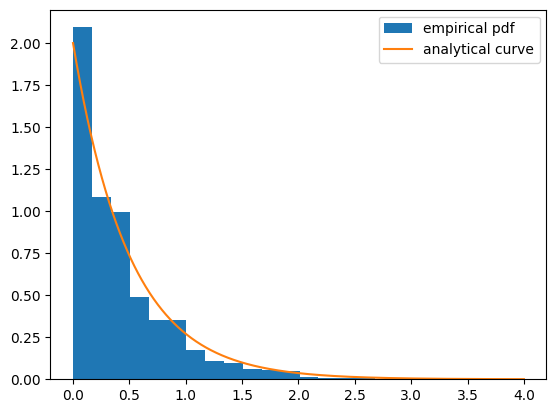

In [118]:
x = np.linspace(0, 4, 1000)

plt.hist(samples, density=True, label='empirical pdf', bins=20)
plt.plot(x, f(x), label='analytical curve')

plt.legend()
plt.show()

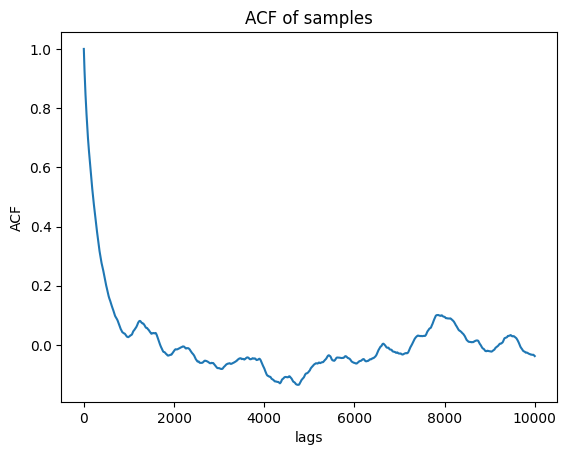

In [120]:
plt.plot(sm.tsa.acf(samples, nlags=10**4))
plt.title('ACF of samples')
plt.xlabel('lags')
plt.ylabel('ACF')

plt.show()

# Problem 3

$$
  y_{1}  =  x_{1} \\  
  y_{2}  =  \exp\big(s_{\theta}(x_{1})\big) \cdot x_{2}  + t_{\theta}(x_{1})\\  
$$

## 1
Let's find Jacobian:
$$\frac{\partial y_1}{\partial x_1} = 1, \frac{\partial y_1}{\partial x_2} = 0$$
$$\frac{\partial y_2}{\partial x_1} = \frac{\partial(\exp\big(s_{\theta}(x_{1})\big) \cdot x_{2}  + t_{\theta}(x_{1}))}{\partial x_1} = \frac{\partial(\exp\big(s_{\theta}(x_{1})\big))}{\partial x_1}\cdot x_{2} + \frac{\partial(t_{\theta}(x_{1}))}{\partial x_1}, \frac{\partial y_2}{\partial x_2} = \exp\big(s_{\theta}(x_{1})\big)$$
Thus:
$$J = \begin{pmatrix}
1, 0 \\
\frac{\partial(\exp\big(s_{\theta}(x_{1})\big) \cdot x_{2}  + t_{\theta}(x_{1}))}{\partial x_1}, \exp\big(s_{\theta}(x_{1})\big)
\end{pmatrix}$$

## 2
With N affine layers we have following formula:
$$p(x_0) = p(x_1)*det(J_1), p(x_1) = p(x_2)*det(J_2), \ldots$$
where $x_0$ - input to network, $x_1$ - output from 1 layer and so on. $x_N$ - output of whole NN. Hence we get:
$$p(x_0) = p(x_N)\prod\limits_{i=1}^{N}det(J_i)$$
$$\log{p(x_0)} = \log{p(x_N)} + \sum\limits_{i=1}^{N}det(J_i) = \log{p(x_N)} + \sum\limits_{i=1}^{N}\exp\big(s_{\theta}(x_{i-1}))$$

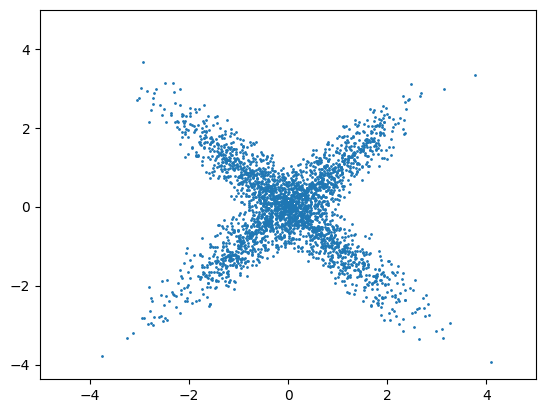

In [121]:
def get_cross(batch_size):
    (uni_x1, uni_x2) = np.random.uniform(0, 1, size=(2, batch_size))
    x = np.random.normal(0, 1, size=batch_size) + uni_x1 * np.cos(2 * np.pi * uni_x2)
    y = np.random.choice([-1, 1], size=batch_size) * x + uni_x1 * np.sin(2 * np.pi * uni_x2)
    x = torch.as_tensor(x, dtype=torch.float32)
    y = torch.as_tensor(y, dtype=torch.float32)
    return torch.column_stack((x, y))

ax_limit = 5
test_size = 3000
target_density = get_cross(test_size)

plt.plot(target_density[:, 0], target_density[:, 1], '.', ms=2)
plt.gca().set_xlim(-ax_limit, ax_limit)
plt.show()

In [122]:
class AffineTransformer(nn.Module):

    def __init__(self, hidden=64, activation=nn.LeakyReLU):
        super().__init__()
        self.input_dim = 1
        self.output_dim = 1
        self.hidden = hidden
        self.scale_net = nn.Sequential(
            nn.Linear(self.input_dim, hidden),
            activation(),
            nn.Linear(hidden, hidden),
            activation(),
            nn.Linear(hidden, hidden),
            activation(),
            nn.Linear(hidden, self.output_dim),
            nn.Tanh(),
        )
        self.translation_net = nn.Sequential(
            nn.Linear(self.input_dim, hidden),
            activation(),
            nn.Linear(hidden, hidden),
            activation(),
            nn.Linear(hidden, hidden),
            activation(),
            nn.Linear(hidden, self.output_dim),
            nn.Tanh(),
        )

    def forward(self, x, alternate):
        x1 = x[:, :1]
        x2 = x[:, 1:]
        if alternate:
            scale = torch.exp(self.scale_net(x1))
            trans = self.translation_net(x1)
            y1 = x1
            y2 = x2 * scale + trans
        else:
            scale = torch.exp(self.scale_net(x2))
            trans = self.translation_net(x2)
            y1 = x1 * scale + trans
            y2 = x2
        y = torch.cat([y1, y2], 1)
        return y, scale, trans

    def inverse(self, y, alternate):
        """MY CODE"""
        y1 = y[:, :1]
        y2 = y[:, 1:]

        if not alternate:
            scale = torch.exp(self.scale_net(y1))
            trans = self.translation_net(y1)
            x1 = y1
            x2 = (y2 - trans) / scale
        else:
            scale = torch.exp(self.scale_net(y2))
            trans = self.translation_net(y2)
            x1 = (y1 - trans) / scale
            x2 = y2

        x = torch.cat([x1, x2], 1)
        return x, scale, trans

In [123]:
class RealNVP(nn.Module):

    def __init__(self, layers=4, hidden=64):
        super().__init__()
        self.layers = layers
        self.hidden = hidden
        # alternating pattern is [False, True, False,  ....]
        self.alternate = [bool(i % 2) for i in range(0, layers)]
        # to register params of transformers we use ModuleList instead of list
        self.transformers = nn.ModuleList([
            AffineTransformer(hidden)
            for _ in range(layers)
        ])
        base_mu = torch.zeros(2)
        base_cov = torch.eye(2)
        self.base_dist = MultivariateNormal(base_mu, base_cov)

    def forward(self, x):
        log_determinant = 0
        for i in range(0, self.layers):
            alternate = self.alternate[i]
            transformer = self.transformers[i]
            x, scale, _ = transformer(x, alternate)
            log_determinant += torch.log(scale).sum(1)
        log_likelihood = self.base_dist.log_prob(x).mean()  # log likelihood of sample under the base measure
        model_loss = - (log_determinant.mean() + log_likelihood)
        return x, model_loss

    def inverse(self, z):
        log_likelihood = self.base_dist.log_prob(z) 
        log_determinant = 0
        for i in reversed(range(0, self.layers)):
            alternate = self.alternate[i]
            transformer = self.transformers[i]
            z, scale, _ = transformer.inverse(z, alternate)
            log_determinant += torch.log(scale).sum(1)
        model_loss = - (log_determinant - log_likelihood).mean()
        return z, model_loss

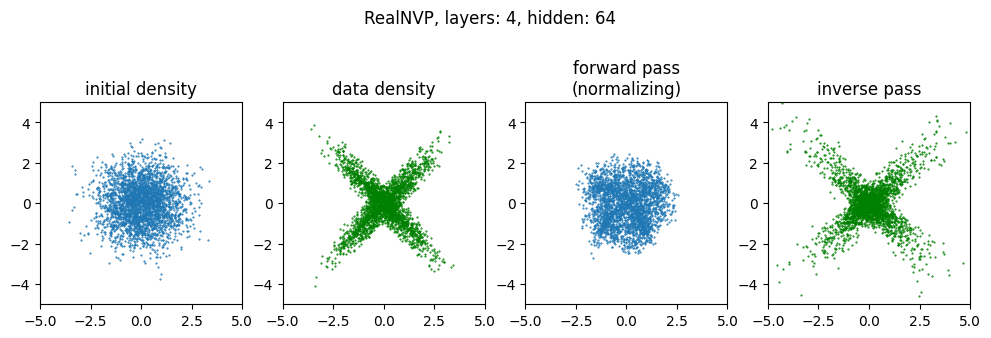

In [124]:
lr = 1e-3
epochs = 100
batch_size = 512
test_size = 3000
loss_track = []

model = RealNVP(layers=4, hidden=64)
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, 0.999)

# train
for b in range(0, epochs):
    batch = get_cross(batch_size)
    optim.zero_grad()
    x, loss = model(batch)
    loss_track.append(loss.detach())
    loss.backward()
    optim.step()
    scheduler.step()

# test
with torch.no_grad():
    base_sample = model.base_dist.rsample((test_size,))
    target_sample = get_cross(test_size)
    forward_pass = model(target_sample)[0]

    # complete the inverse function to run an inverse pass
    inverse_pass = model.inverse(base_sample)[0]
    
    # --------------- visualisation
    ms = 1
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 4))
    fig.suptitle(f'RealNVP, layers: {model.layers}, hidden: {model.hidden}')
    
    ax1.set_title('initial density')
    ax1.plot(base_sample[:, 0], base_sample[:, 1], '.', ms=ms)
    
    ax2.set_title(f'data density')
    ax2.plot(target_sample[:, 0], target_sample[:, 1], '. g', ms=ms)
    
    ax3.set_title('forward pass\n(normalizing)')
    ax3.plot(forward_pass[:, 0], forward_pass[:, 1], '.', ms=ms)

    # complete the inverse function to run an inverse pass
    ax4.set_title('inverse pass')
    ax4.plot(inverse_pass[:, 0], inverse_pass[:, 1], '. g', ms=ms)
    
    for ax in (ax1, ax2, ax3, ax4):
        ax_limit = 5
        ax.set_aspect('equal')
        ax.set_xlim(-ax_limit, ax_limit)
        ax.set_ylim(-ax_limit, ax_limit)

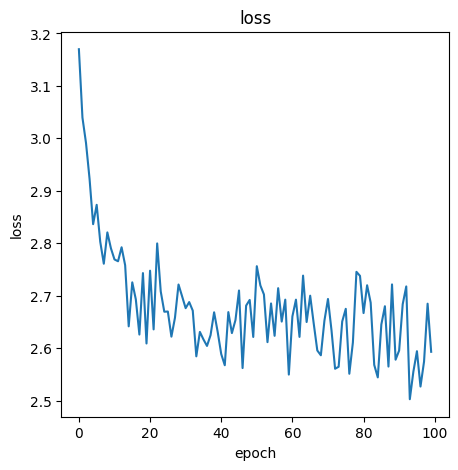

In [125]:
fig2, ax2_1 = plt.subplots(1, 1, figsize=(5, 5))
ax2_1.set_title('loss')
ax2_1.plot(loss_track)
ax2_1.set_xlabel('epoch')
ax2_1.set_ylabel('loss')
plt.show()

# Problem 4

## 1

$\pi^T(X_0, X_1) = \pi_0(X_0) \times \delta(X_1 - T(X_0))$, $X_0 \sim \pi_0(X_0)$, $T(X_0) \sim \pi_1$

$$\int \pi_0(x) \times \delta(X_1 - T(x)) dx = \int \pi_1(T(x)) \times \delta(X_1 - T(x)) dT(x) = \pi_1(T(x)) |_{T(x) = X_1} = \pi_1(X_1)$$
$$\int \pi_0(X_0) \times \delta(x - T(X_0)) dx = \pi_0(X_0) \int \delta(x - T(X_0)) dx = \pi_0(X_0)$$

In first equation condition $\pi_0(x)dx = \pi_1(T(x))dT(x)$ was used. In second - $\pi_0(X_0)$ does not depend on $X_1$ and integral of delta function is 1.

## 2

We should prove:
$$E\|Z_1-Z_0\|^2 \leq E\|X_1-X_0\|^2$$
Since $Z_1 = Z_0 + \int\limits_{t=0}^1v_{\theta}(Z_t, t)dt$:
$$E\|Z_1-Z_0\|^2 = E\|\int\limits_{t=0}^1v_{\theta}(Z_t, t)dt\|^2$$
We know that square norm is convex function: $\forall t \in [0..1]:\|tA+(1-t)B\|^2 \leq (t\|A\|+(1-t)\|B\|)^2 = t^2\|A\|^2 + (1-t)^2\|B\|^2 + \\ + 2t(1-t)\|A\|\|B\| \leq t^2\|A\|^2 + (1-t)^2\|B\|^2 \leq t\|A\|^2 + (1-t)\|B\|^2$. Since norm is non-negative, t non-negative too, and $t^2 \leq t\ \forall t \in [0, 1]$. Thus, by Jensen inequality, we got:
$$E\|\int\limits_{t=0}^1v_{\theta}(Z_t, t)dt\|^2 \leq E(\int\limits_{t=0}^1\|v_{\theta}(Z_t, t)\|^2dt)$$
Also, $X_0$ and $Z_0$ distributed by the same law $\pi_0$. And $X_1$ with $Z_1$ by $\pi_1$. Hence we just can change symbols:
$$E(\int\limits_{t=0}^1\|v_{\theta}(Z_t, t)\|^2dt) = E(\int\limits_{t=0}^1\|v_{\theta}(X_t, t)\|^2dt)$$
Now, if we look at difinition of $v_{\theta}(X_t, t)$:
$$v_{\theta}(X_t, t) = \argmin_{v} \int\limits_0^1E(\|(X_1 - X_0) - v_{\theta}(X_t, t)\|^2)dt$$
Let's look at some point t at this equation. Let $X_t = x$.
$$v_{\theta}(x, t) = \argmin_v E(\|(X_1 - X_0) - v_{\theta}(x, t)\|^2| X_t = x)$$
Using first order optimality condition, we got:
$$(E(\|(X_1 - X_0) - v_{\theta}(x, t)\|^2 | X_t = x))_v^{'} = E((\|(X_1 - X_0) - v_{\theta}(x, t)\|^2)_v^{'}| X_t=x) = E(-2((X_1 - X_0) - v_{\theta}(x, t))|X_t=x) = 0$$
$$E[-2((X_1 - X_0) - v_{\theta}(x, t))|X_t=x] = 0 \to E[((X_1 - X_0) - v_{\theta}(x, t))|X_t=x] = 0 \to v_{\theta}(x, t) = E[X_1 - X_0|X_t=x]$$
Thus $v_{\theta}(x, t) = E[X_1 - X_0| X_t = x]$ or $v_{\theta}(X_t, t) = E[X_1 - X_0| X_t]$. Substitute with it in our integral:
$$E[\int\limits_{t=0}^1\|v_{\theta}(X_t, t)\|^2dt] = E[\int\limits_{t=0}^1\|E[X_1 - X_0| X_t]\|^2dt]$$
Again, let's use Jensen inequality:
$$E[\int\limits_{t=0}^1\|E[X_1 - X_0| X_t]\|^2dt] \leq E[\int\limits_{t=0}^1E[\|X_1 - X_0\|^2| X_t]dt] = \int\limits_{t=0}^1E[E[\|X_1 - X_0\|^2| X_t]]dt$$
Since $X_t = tX_1 + (1 - t)X_0 \to X_t \sim \pi_0 \times \pi_1$, , we can use law of total expectation:
$$\int\limits_{t=0}^1E[E[\|X_1 - X_0\|^2| X_t]]dt = \int\limits_{t=0}^1 E[\|X_1 - X_0\|^2]dt = E[\|X_1 - X_0\|^2]$$
Finally, we got:
$$E\|Z_1-Z_0\|^2 \leq E\|X_1-X_0\|^2$$

## 3

## Generating Distribution $\pi_0$ and $\pi_1$
We generate $\pi_0$ and $\pi_1$ as two Gaussian mixture models with different modes.

We sample 10000 data points from $\pi_0$ and $\pi_1$, respectively,
and store them in ```samples_0```, ```samples_1```.

Shape of the samples: torch.Size([10000, 2]) torch.Size([10000, 2])


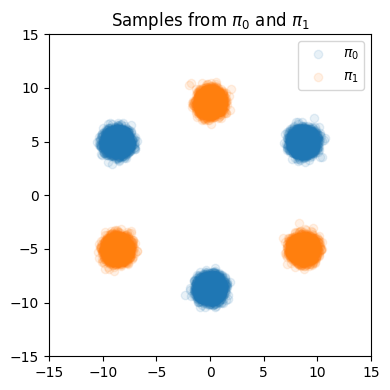

In [2]:
D = 10.
M = D+5
VAR = 0.3
DOT_SIZE = 4
COMP = 3

initial_mix = Categorical(torch.tensor([1/COMP for i in range(COMP)]))
initial_comp = MultivariateNormal(torch.tensor([[D * np.sqrt(3) / 2., D / 2.], [-D * np.sqrt(3) / 2., D / 2.], [0.0, - D * np.sqrt(3) / 2.]]).float(), VAR * torch.stack([torch.eye(2) for i in range(COMP)]))
initial_model = MixtureSameFamily(initial_mix, initial_comp)
samples_0 = initial_model.sample([10000])

target_mix = Categorical(torch.tensor([1/COMP for i in range(COMP)]))
target_comp = MultivariateNormal(torch.tensor([[D * np.sqrt(3) / 2., - D / 2.], [-D * np.sqrt(3) / 2., - D / 2.], [0.0, D * np.sqrt(3) / 2.]]).float(), VAR * torch.stack([torch.eye(2) for i in range(COMP)]))
target_model = MixtureSameFamily(target_mix, target_comp)
samples_1 = target_model.sample([10000])
print('Shape of the samples:', samples_0.shape, samples_1.shape)

plt.figure(figsize=(4,4))
plt.xlim(-M,M)
plt.ylim(-M,M)
plt.title(r'Samples from $\pi_0$ and $\pi_1$')
plt.scatter(samples_0[:, 0].cpu().numpy(), samples_0[:, 1].cpu().numpy(), alpha=0.1, label=r'$\pi_0$')
plt.scatter(samples_1[:, 0].cpu().numpy(), samples_1[:, 1].cpu().numpy(), alpha=0.1, label=r'$\pi_1$')
plt.legend()

plt.tight_layout()

## Define the Flow Model
Given empirical observations of $X_0\sim \pi_0$ and $X_1\sim \pi_1$,
the rectified flow induced from $(X_0,X_1)$
is an ordinary differentiable model (ODE)
on time $t\in[0,1]$,
$$
d Z_t = v^X(Z_t, t) d t,
$$
which $v$ is set in a way that ensures that $Z_1$ follows $\pi_1$ when $Z_0 \sim \pi_0$. Let $X_t = t X_1 + (1-t)X_0$ be the linear interpolation of $X_0$ and $X_1$. Then $v$ is given by
$$
v^X(z,t) = \mathbb{E}[X_1 - X_0 ~|~ X_t = z  ] =  \arg\min_{v} \int_0^1 \mathbb{E}[|| X_1-X_0 - v(X_t,t) ||^2] \mathrm{d} t,
$$
where the (conditional) expectation is w.r.t. the joint distribution of $(X_0,X_1)$.

We parameterize $v^X(z,t)$ with a 3-layer neural network.

In [3]:
class MLP(nn.Module):
    def __init__(self, input_dim=2, hidden_num=100):
        super().__init__()
        self.fc1 = nn.Linear(input_dim+1, hidden_num, bias=True)
        self.fc2 = nn.Linear(hidden_num, hidden_num, bias=True)
        self.fc3 = nn.Linear(hidden_num, input_dim, bias=True)
        self.act = lambda x: torch.tanh(x)

    def forward(self, x_input, t):
        inputs = torch.cat([x_input, t], dim=1)
        x = self.fc1(inputs)
        x = self.act(x)
        x = self.fc2(x)
        x = self.act(x)
        x = self.fc3(x)

        return x

Then we define the rectfied flow class.

In [4]:
class RectifiedFlow():
  def __init__(self, model=None, num_steps=1000):
    self.model = model
    self.N = num_steps

  def get_train_tuple(self, z0=None, z1=None):
    t = torch.rand((z1.shape[0], 1))
    z_t =  t * z1 + (1.-t) * z0
    target = z1 - z0

    return z_t, t, target

  @torch.no_grad()
  def sample_ode(self, z0=None, N=None):
    ### NOTE: Use Euler method to sample from the learned flow
    if N is None:
      N = self.N
    dt = 1./N
    traj = [] # to store the trajectory
    z = z0.detach().clone()
    batchsize = z.shape[0]

    traj.append(z.detach().clone())
    for i in range(N):
      t = torch.ones((batchsize,1)) * i / N
      pred = self.model(z, t)
      z = z.detach().clone() + pred * dt

      traj.append(z.detach().clone())

    return traj

## Define the training method and other misc. code
We define the training method here. The loss function is:
$$
\min_{\theta}
\int_0^1 E_{X_0 \sim \pi_0, X_1 \sim \pi_1} \left [ {||( X_1 - X_0) - v_\theta\big (X_t,~ t\big)||}^2
\right ] \text{d}t,
~~~~~\text{with}~~~~
X_t = t X_1 + (1-t) X_0.
$$

In [5]:
def train_rectified_flow(rectified_flow, optimizer, pairs, batchsize, inner_iters):
  loss_curve = []
  for i in range(inner_iters+1):
    optimizer.zero_grad()
    indices = torch.randperm(len(pairs))[:batchsize]
    batch = pairs[indices]
    z0 = batch[:, 0].detach().clone()
    z1 = batch[:, 1].detach().clone()
    z_t, t, target = rectified_flow.get_train_tuple(z0=z0, z1=z1)

    pred = rectified_flow.model(z_t, t)
    loss = (target - pred).view(pred.shape[0], -1).abs().pow(2).sum(dim=1)
    loss = loss.mean()
    loss.backward()

    optimizer.step()
    loss_curve.append(np.log(loss.item())) ## to store the loss curve

  return rectified_flow, loss_curve


In [6]:
@torch.no_grad()
def draw_plot(rectified_flow, z0, z1, N=None):
  traj = rectified_flow.sample_ode(z0=z0, N=N)

  plt.figure(figsize=(4,4))
  plt.xlim(-M,M)
  plt.ylim(-M,M)

  plt.scatter(z1[:, 0].cpu().numpy(), z1[:, 1].cpu().numpy(), label=r'$\pi_1$', alpha=0.15)
  plt.scatter(traj[0][:, 0].cpu().numpy(), traj[0][:, 1].cpu().numpy(), label=r'$\pi_0$', alpha=0.15)
  plt.scatter(traj[-1][:, 0].cpu().numpy(), traj[-1][:, 1].cpu().numpy(), label='Generated', alpha=0.15)
  plt.legend()
  plt.title('Distribution')
  plt.tight_layout()

  traj_particles = torch.stack(traj)
  plt.figure(figsize=(4,4))
  plt.xlim(-M,M)
  plt.ylim(-M,M)
  plt.axis('equal')
  for i in range(30):
    plt.plot(traj_particles[:, i, 0], traj_particles[:, i, 1])
  plt.title('Transport Trajectory')
  plt.tight_layout()

## 1-Rectified Flow
We start by generating the pairs $(X_0, X_1)$ by pooling randomly sampled points from ```sample_0``` and ```sample_1```. So $(X_0,X_1)$ forms an independent coupling of $\pi_0$ and $\pi_1$.

In [7]:
x_0 = samples_0.detach().clone()[torch.randperm(len(samples_0))]
x_1 = samples_1.detach().clone()[torch.randperm(len(samples_1))]
x_pairs = torch.stack([x_0, x_1], dim=1)
print(x_pairs.shape)

torch.Size([10000, 2, 2])


We create ```rectified_flow_1``` and its corresponding ```optimizer``` and traing 1-Rectified Flow with ```train_rectified_flow``` using $(X_0, X_1)$ above.

Text(0.5, 1.0, 'Training Loss Curve')

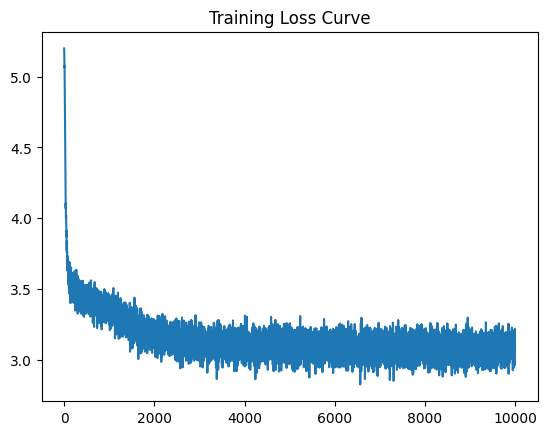

In [8]:
iterations = 10000
batchsize = 2048
input_dim = 2

rectified_flow_1 = RectifiedFlow(model=MLP(input_dim, hidden_num=100), num_steps=100)
optimizer = torch.optim.Adam(rectified_flow_1.model.parameters(), lr=5e-3)

rectified_flow_1, loss_curve = train_rectified_flow(rectified_flow_1, optimizer, x_pairs, batchsize, iterations)
plt.plot(np.linspace(0, iterations, iterations+1), loss_curve[:(iterations+1)])
plt.title('Training Loss Curve')

We run the Euler method to solve the ODE with $N=100$ steps to generate samples from 1-Rectified Flow.

Orange dots = samples from $\pi_0$

Blue dots   = samples from $\pi_1$

Green dots  = samples from 1-Rectified Flow

1-Rectified Flow successfully learned a velocity field $v(Z_t, t)$ that can transport $\pi_0$ to $\pi_1$.

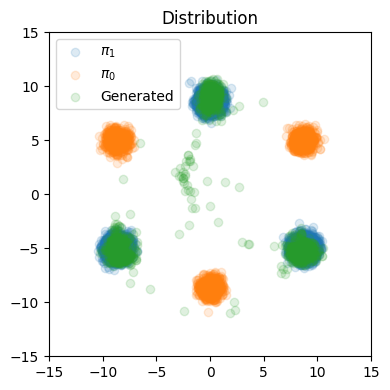

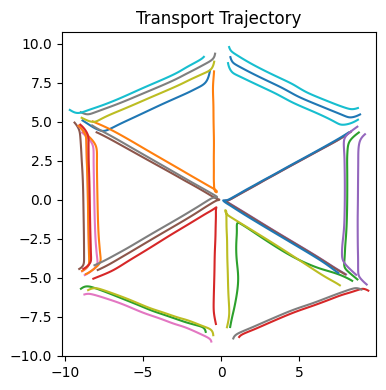

In [9]:
draw_plot(rectified_flow_1, z0=initial_model.sample([2000]), z1=samples_1.detach().clone(), N=100)

We can see that the trajectories above fit well on the trajectories of linear intepolation of data, but are "rewired" in the center when the trajectories are intersect. Hence, the resulting trajectories are either (almost)straight, or has a ">" shape.

Due to the non-straight ">"-shape paths, if we simulate the ODE with a small step $N$, we would obtain poor performance, as shown below ($N=1$).

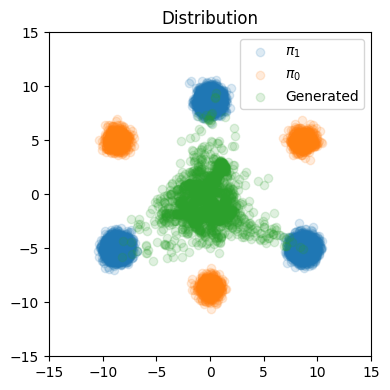

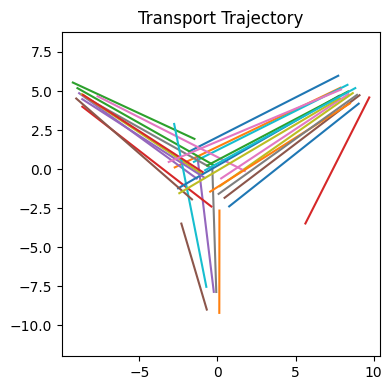

In [29]:
draw_plot(rectified_flow_1, z0=initial_model.sample([2000]), z1=samples_1.detach().clone(), N=1)

## Reflow for 2-Rectified Flow
Now let's use the *reflow* procedure to get a straightened rectified flow,
denoted as 2-Rectified Flow, by repeating the same procedure on with $(X_0,X_1)$ replaced by  $(Z_0^1, Z_1^1)$, where   $(Z_0^1, Z_1^1)$ is the coupling simulated from 1-Rectified Flow.  
Specifically, we randomly sample 10000 $Z_0^1$  and generate their corresponding  $Z_1^1$ by simulating 1-Rectified Flow.

In [30]:
z10 = samples_0.detach().clone()
traj = rectified_flow_1.sample_ode(z0=z10.detach().clone(), N=100)
z11 = traj[-1].detach().clone()
z_pairs = torch.stack([z10, z11], dim=1)
print(z_pairs.shape)

torch.Size([10000, 2, 2])


The coupling $(Z_0^1, Z_1^1)$ is now deterministic. The loss function is:
$$
\min_{\theta}
\int_0^1 E_{(Z_0, Z_1) \sim (Z_0^1, Z_1^1)} \left [ {||( Z_1 - Z_0) - v_\theta\big (Z_t,~ t\big)||}^2
\right ] \text{d}t,
~~~~~\text{with}~~~~
Z_t = t Z_1 + (1-t) Z_0.
$$

We create ```rectified_flow_2``` and its corresponding ```optimizer``` and traing 2-Rectified Flow with ```train_rectified_flow```.

We use the model pretrained in 1-Rectified Flow to accelerate training.

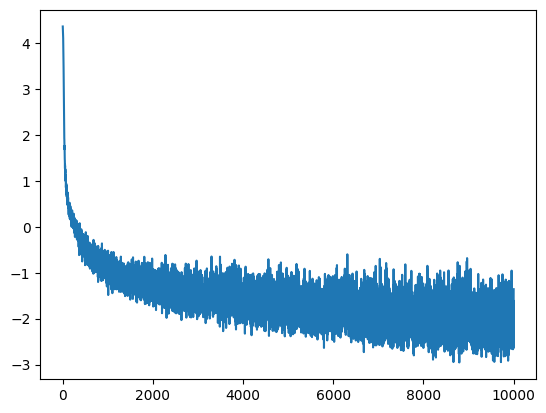

In [31]:
reflow_iterations = 10000

rectified_flow_2 = RectifiedFlow(model=MLP(input_dim, hidden_num=100), num_steps=100)
import copy
rectified_flow_2.net = copy.deepcopy(rectified_flow_1) # we fine-tune the model from 1-Rectified Flow for faster training.
optimizer = torch.optim.Adam(rectified_flow_2.model.parameters(), lr=5e-3)

rectified_flow_2, loss_curve = train_rectified_flow(rectified_flow_2, optimizer, z_pairs, batchsize, reflow_iterations)
plt.plot(np.linspace(0, reflow_iterations, reflow_iterations+1), loss_curve[:(reflow_iterations+1)])

We run the Euler method to solve the ODE with $N=100$ steps to generate samples from 2-Rectified Flow.

2-Rectified Flow can also successfully learn a velocity field $v(Z_t, t)$ that can transport $\pi_0$ to $\pi_1$.

The key point, however, is that the transport trajectory is now **straightened** and hence we would not lose much accuracy even if we solve the ODE with one Euler step ($N=1$).

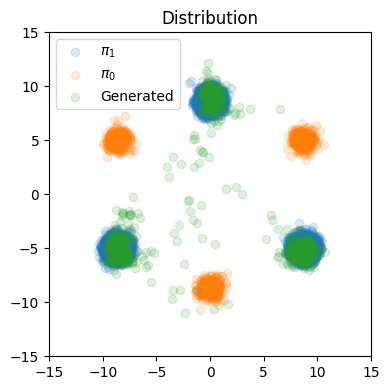

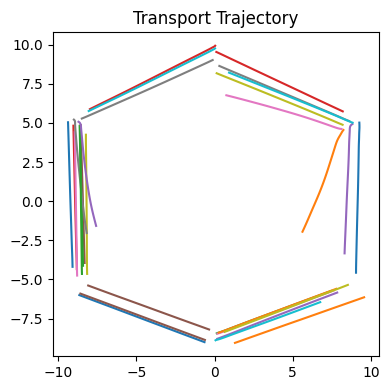

In [32]:
draw_plot(rectified_flow_2, z0=initial_model.sample([1000]), z1=samples_1.detach().clone(), N=100)

So below is the result when we solve the ODE with $N=1$ Euler step to generate samples from 2-Rectified Flow.

With the **straightened** trajectory, we get almost perfect results with only  one-step generation! Thanks to the power of **Reflow** !

More croncretely, the output of the model is now $Z_1 = Z_0 + v(Z_0, 0)$.

Effectively, we have trained a one-step model, by using ODE as an intermediate step.

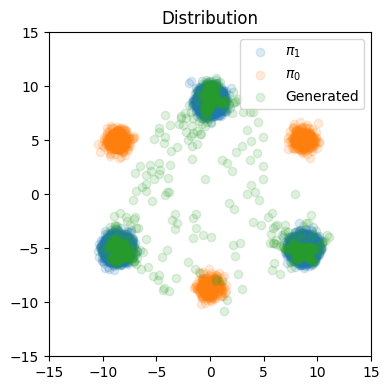

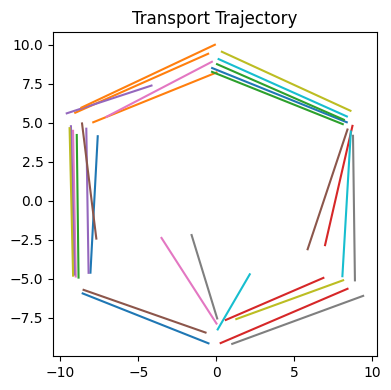

In [33]:
draw_plot(rectified_flow_2, z0=initial_model.sample([1000]), z1=samples_1.detach().clone(), N=1)

## Reflow for 3-Rectified Flow

In [34]:
z20 = samples_0.detach().clone()
traj = rectified_flow_2.sample_ode(z0=z20.detach().clone(), N=100)
z21 = traj[-1].detach().clone()
z_pairs = torch.stack([z20, z21], dim=1)
print(z_pairs.shape)

torch.Size([10000, 2, 2])


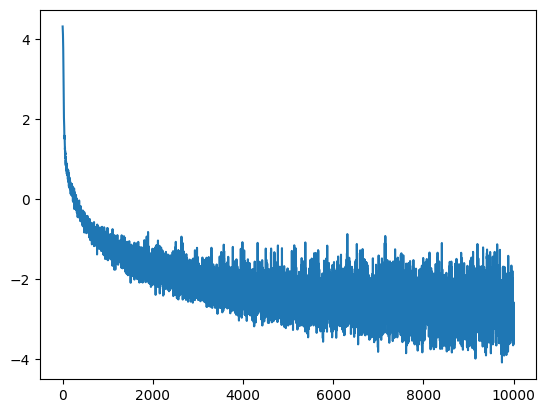

In [35]:
reflow_iterations = 10000

rectified_flow_3 = RectifiedFlow(model=MLP(input_dim, hidden_num=100), num_steps=100)

rectified_flow_3.net = copy.deepcopy(rectified_flow_2) # we fine-tune the model from 2-Rectified Flow for faster training.
optimizer = torch.optim.Adam(rectified_flow_3.model.parameters(), lr=5e-3)

rectified_flow_3, loss_curve = train_rectified_flow(rectified_flow_3, optimizer, z_pairs, batchsize, reflow_iterations)
plt.plot(np.linspace(0, reflow_iterations, reflow_iterations+1), loss_curve[:(reflow_iterations+1)])

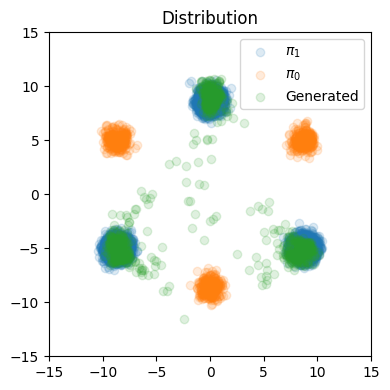

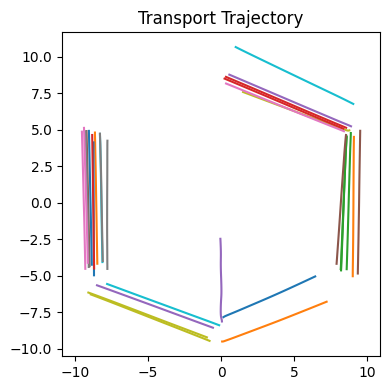

In [36]:
draw_plot(rectified_flow_3, z0=initial_model.sample([1000]), z1=samples_1.detach().clone(), N=100)

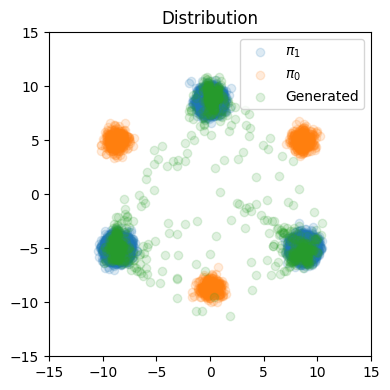

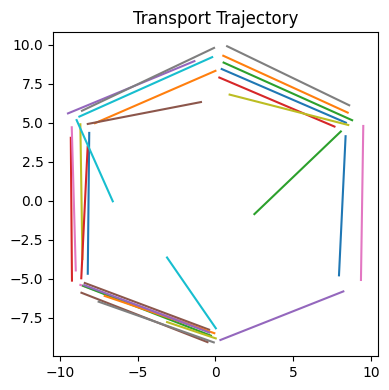

In [37]:
draw_plot(rectified_flow_3, z0=initial_model.sample([1000]), z1=samples_1.detach().clone(), N=1)

## Reflow for 4-Rectified Flow

In [38]:
z30 = samples_0.detach().clone()
traj = rectified_flow_3.sample_ode(z0=z30.detach().clone(), N=100)
z31 = traj[-1].detach().clone()
z_pairs = torch.stack([z30, z31], dim=1)
print(z_pairs.shape)

torch.Size([10000, 2, 2])


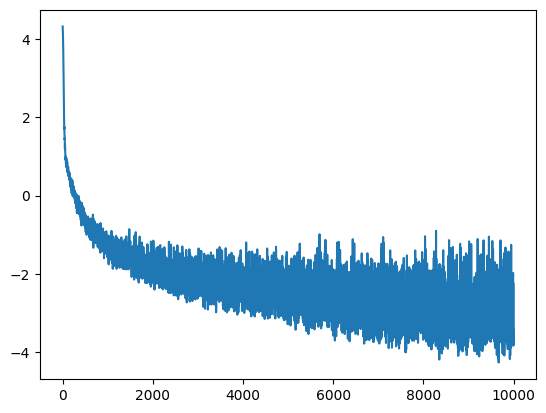

In [39]:
reflow_iterations = 10000

rectified_flow_4 = RectifiedFlow(model=MLP(input_dim, hidden_num=100), num_steps=100)
import copy
rectified_flow_4.net = copy.deepcopy(rectified_flow_3) # we fine-tune the model from 3-Rectified Flow for faster training.
optimizer = torch.optim.Adam(rectified_flow_4.model.parameters(), lr=5e-3)

rectified_flow_4, loss_curve = train_rectified_flow(rectified_flow_4, optimizer, z_pairs, batchsize, reflow_iterations)
plt.plot(np.linspace(0, reflow_iterations, reflow_iterations+1), loss_curve[:(reflow_iterations+1)])

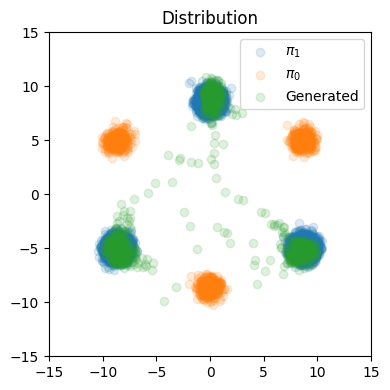

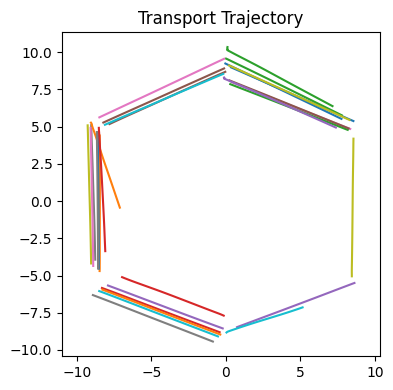

In [40]:
draw_plot(rectified_flow_4, z0=initial_model.sample([1000]), z1=samples_1.detach().clone(), N=100)

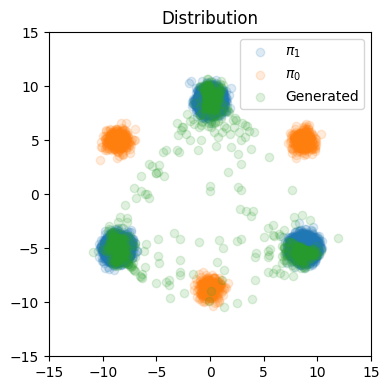

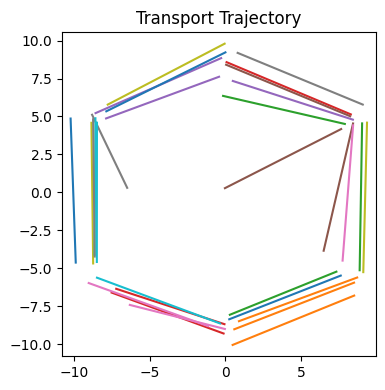

In [41]:
draw_plot(rectified_flow_4, z0=initial_model.sample([1000]), z1=samples_1.detach().clone(), N=1)

We can see from results above, that 3 and 4-Rectified Flows not improved result of 2 Rectified Flow. 1 step ODE become more and more strange, transport lines not so straight in 4 RF as in 2 RF. Also, target distribution samples of $T_{3-rectified}$ and $T_{4-rectified}$ become more noisy and look not so accurate, or in other words they fit true target distribution worse. It may accure because for $T_{n-rectified}$ flow we use as a target not true samples from $\pi_1$, but those samples, obtained with $T_{(n-1)-rectified}$ flow, so our target distribution shifts a little bit.

## 4

Let's learn inverse trajectories.

## 2-Rectified Flow

In [10]:
class RectifiedFlowInverse():
  def __init__(self, model=None, num_steps=1000):
    self.model = model
    self.N = num_steps

  def get_train_tuple(self, z0=None, z1=None):
    t = torch.rand((z1.shape[0], 1))
    z_t =  t * z1 + (1.-t) * z0
    target = z0 - z1

    return z_t, t, target

  @torch.no_grad()
  def sample_ode(self, z1=None, N=None):
    if N is None:
      N = self.N
    dt = 1./N
    traj = [] # to store the trajectory
    z = z1.detach().clone()
    batchsize = z.shape[0]

    traj.append(z.detach().clone())
    for i in range(N):
      t = torch.ones((batchsize,1)) * (N - 1 - i) / N
      pred = self.model(z, t)
      z = z.detach().clone() + pred * dt

      traj.append(z.detach().clone())

    return traj

In [11]:
@torch.no_grad()
def draw_plot_inv(rectified_flow_inv, z0, z1, N=None):
  traj = rectified_flow_inv.sample_ode(z1=z1, N=N)

  plt.figure(figsize=(4,4))
  plt.xlim(-M,M)
  plt.ylim(-M,M)

  plt.scatter(z0[:, 0].cpu().numpy(), z0[:, 1].cpu().numpy(), label=r'$\pi_0$', alpha=0.15)
  plt.scatter(traj[0][:, 0].cpu().numpy(), traj[0][:, 1].cpu().numpy(), label=r'$\pi_1$', alpha=0.15)
  plt.scatter(traj[-1][:, 0].cpu().numpy(), traj[-1][:, 1].cpu().numpy(), label='Generated', alpha=0.15)
  plt.legend()
  plt.title('Distribution')
  plt.tight_layout()

  traj_particles = torch.stack(traj)
  plt.figure(figsize=(4,4))
  plt.xlim(-M,M)
  plt.ylim(-M,M)
  plt.axis('equal')
  for i in range(30):
    plt.plot(traj_particles[:, i, 0], traj_particles[:, i, 1])
  plt.title('Transport Trajectory')
  plt.tight_layout()

In [12]:
z10 = samples_0.detach().clone()
traj = rectified_flow_1.sample_ode(z0=z10.detach().clone(), N=100)
z11 = traj[-1].detach().clone()
z_pairs = torch.stack([z10, z11], dim=1)
print(z_pairs.shape)

torch.Size([10000, 2, 2])


Text(0.5, 1.0, 'Training Loss Curve')

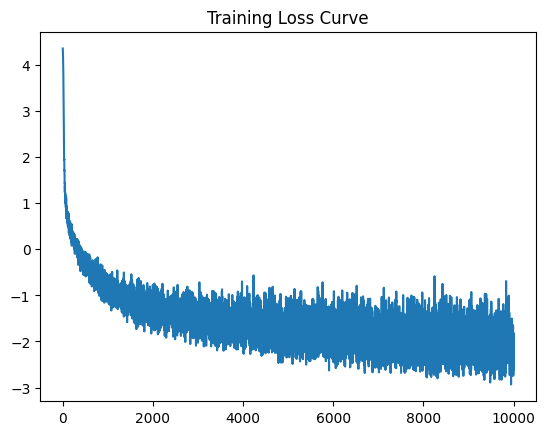

In [13]:
iterations = 10000
batchsize = 2048
input_dim = 2

rectified_flow_2_inv = RectifiedFlowInverse(model=MLP(input_dim, hidden_num=100), num_steps=100)
optimizer = torch.optim.Adam(rectified_flow_2_inv.model.parameters(), lr=5e-3)

rectified_flow_2_inv, loss_curve = train_rectified_flow(rectified_flow_2_inv, optimizer, z_pairs, batchsize, iterations)
plt.plot(np.linspace(0, iterations, iterations+1), loss_curve[:(iterations+1)])
plt.title('Training Loss Curve')

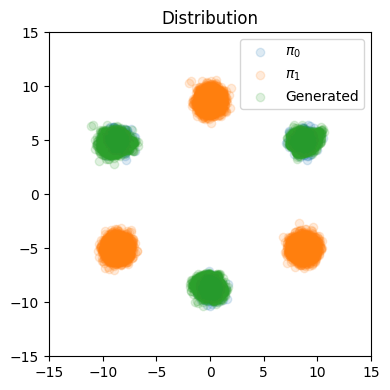

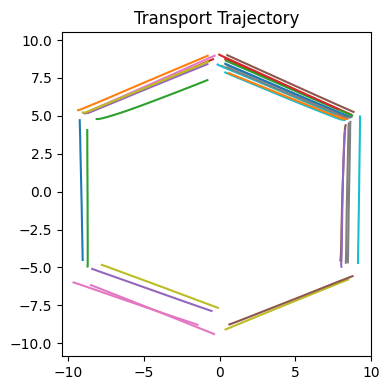

In [15]:
draw_plot_inv(rectified_flow_2_inv, z0=initial_model.sample([1000]), z1=samples_1.detach().clone(), N=100)

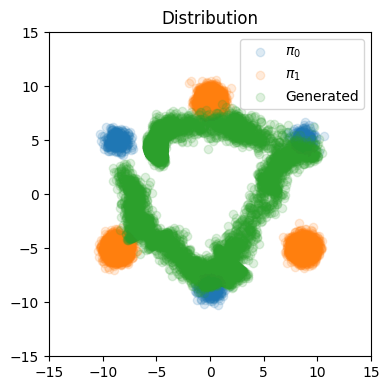

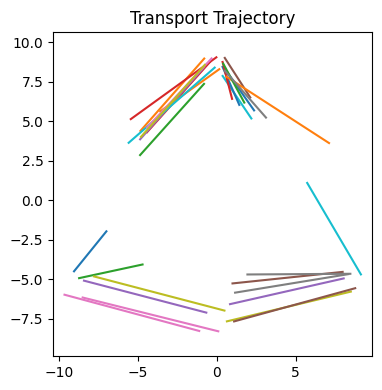

In [16]:
draw_plot_inv(rectified_flow_2_inv, z0=initial_model.sample([1000]), z1=samples_1.detach().clone(), N=1)

## 3-Rectified Flow

In [18]:
z21 = samples_1.detach().clone()
traj = rectified_flow_2_inv.sample_ode(z1=z21.detach().clone(), N=100)
z20 = traj[-1].detach().clone()
z_pairs = torch.stack([z20, z21], dim=1)
print(z_pairs.shape)

torch.Size([10000, 2, 2])


Text(0.5, 1.0, 'Training Loss Curve')

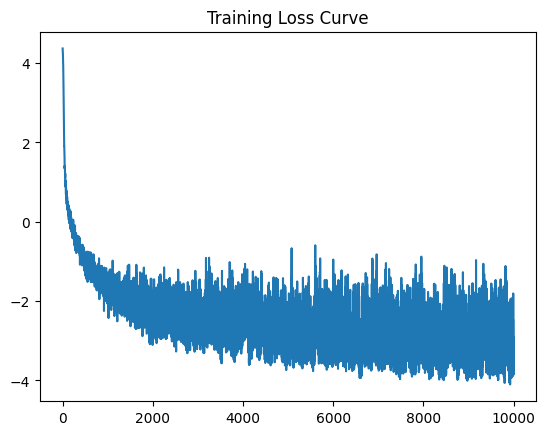

In [21]:
iterations = 10000
batchsize = 2048
input_dim = 2

rectified_flow_3_inv = RectifiedFlowInverse(model=MLP(input_dim, hidden_num=100), num_steps=100)
rectified_flow_3_inv.net = copy.deepcopy(rectified_flow_2_inv)
optimizer = torch.optim.Adam(rectified_flow_3_inv.model.parameters(), lr=5e-3)

rectified_flow_3_inv, loss_curve = train_rectified_flow(rectified_flow_3_inv, optimizer, z_pairs, batchsize, iterations)
plt.plot(np.linspace(0, iterations, iterations+1), loss_curve[:(iterations+1)])
plt.title('Training Loss Curve')

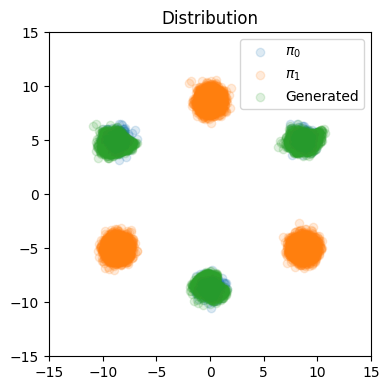

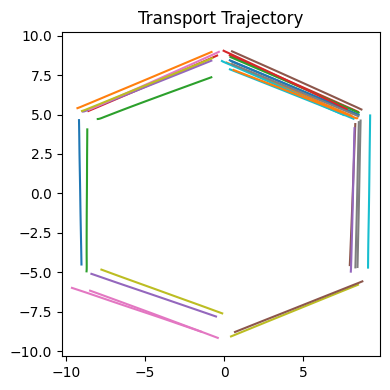

In [22]:
draw_plot_inv(rectified_flow_3_inv, z0=initial_model.sample([1000]), z1=samples_1.detach().clone(), N=100)

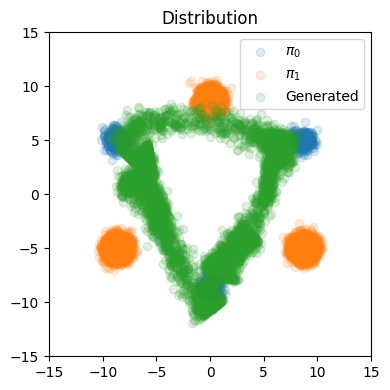

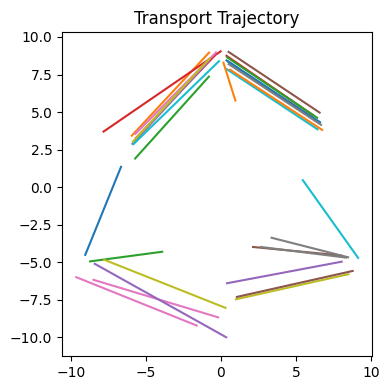

In [23]:
draw_plot_inv(rectified_flow_3_inv, z0=initial_model.sample([1000]), z1=samples_1.detach().clone(), N=1)

## 4-Rectified Flow

In [24]:
z31 = samples_1.detach().clone()
traj = rectified_flow_3_inv.sample_ode(z1=z31.detach().clone(), N=100)
z30 = traj[-1].detach().clone()
z_pairs = torch.stack([z30, z31], dim=1)
print(z_pairs.shape)

torch.Size([10000, 2, 2])


Text(0.5, 1.0, 'Training Loss Curve')

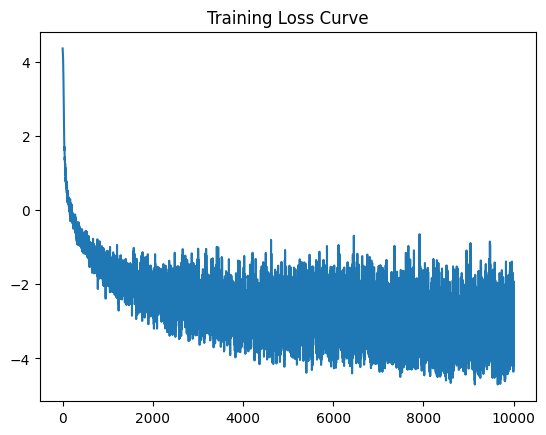

In [25]:
iterations = 10000
batchsize = 2048
input_dim = 2

rectified_flow_4_inv = RectifiedFlowInverse(model=MLP(input_dim, hidden_num=100), num_steps=100)
rectified_flow_4_inv.net = copy.deepcopy(rectified_flow_3_inv)
optimizer = torch.optim.Adam(rectified_flow_4_inv.model.parameters(), lr=5e-3)

rectified_flow_4_inv, loss_curve = train_rectified_flow(rectified_flow_4_inv, optimizer, z_pairs, batchsize, iterations)
plt.plot(np.linspace(0, iterations, iterations+1), loss_curve[:(iterations+1)])
plt.title('Training Loss Curve')

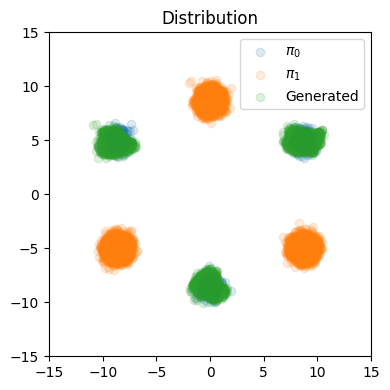

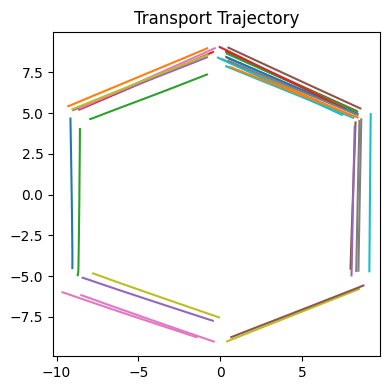

In [26]:
draw_plot_inv(rectified_flow_4_inv, z0=initial_model.sample([1000]), z1=samples_1.detach().clone(), N=100)

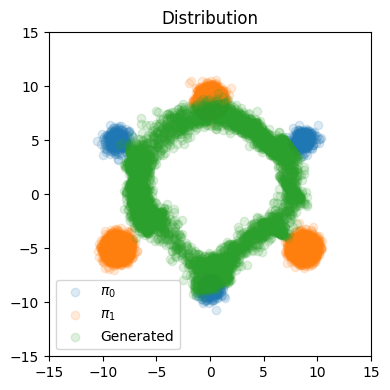

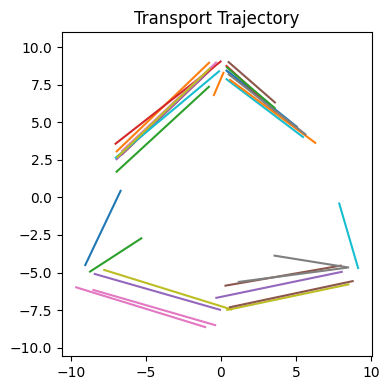

In [27]:
draw_plot_inv(rectified_flow_4_inv, z0=initial_model.sample([1000]), z1=samples_1.detach().clone(), N=1)

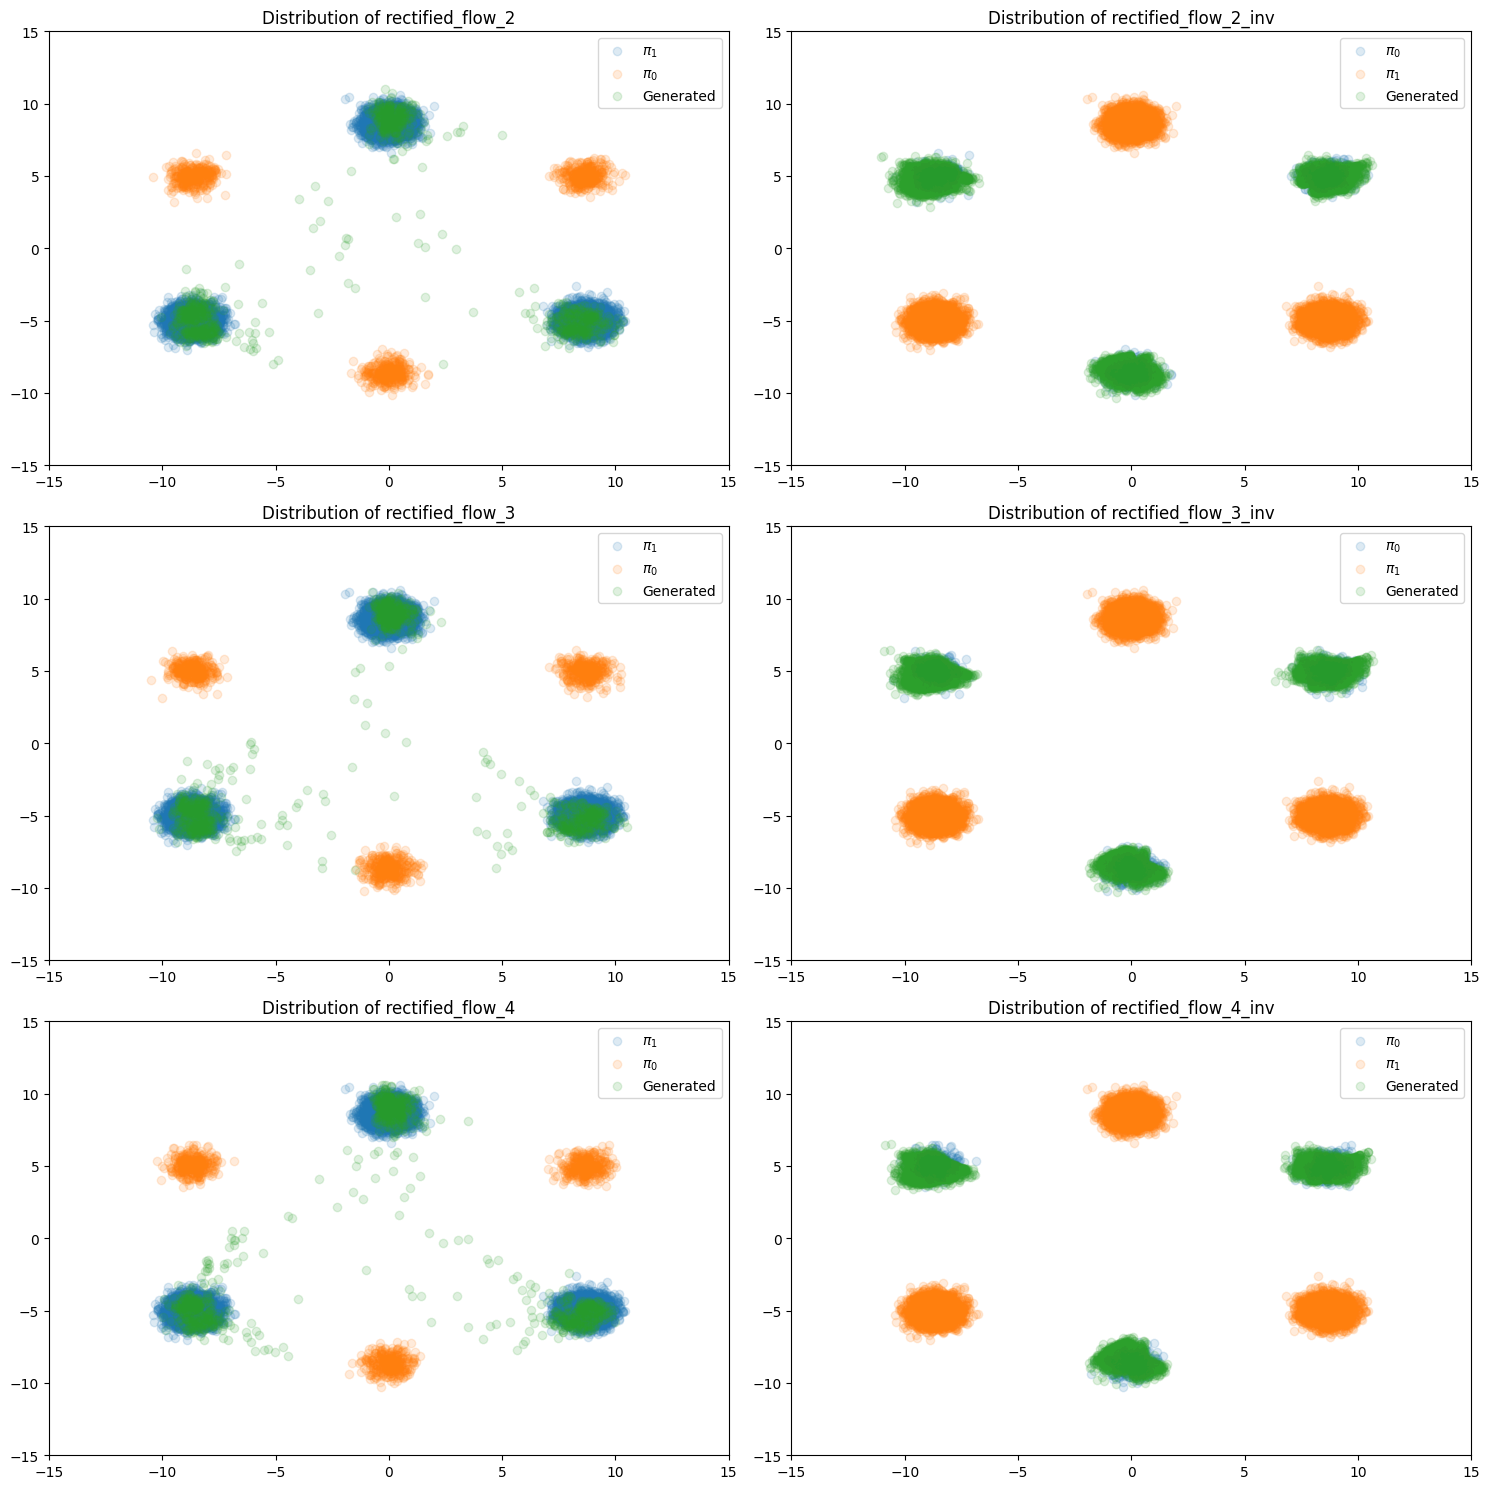

In [42]:
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
flows = [(rectified_flow_2, rectified_flow_2_inv), (rectified_flow_3, rectified_flow_3_inv), 
         (rectified_flow_4, rectified_flow_4_inv)]
names = [('rectified_flow_2', 'rectified_flow_2_inv'), ('rectified_flow_3', 'rectified_flow_3_inv'), 
         ('rectified_flow_4', 'rectified_flow_4_inv')]

for i, ax in enumerate(axes):
    z0 = initial_model.sample([1000])
    z1 = samples_1.detach().clone()

    traj = flows[i][0].sample_ode(z0=z0, N=100)
    ax[0].set_xlim(-M,M)
    ax[0].set_ylim(-M,M)
    #v.scatter()

    ax[0].scatter(z1[:, 0].cpu().numpy(), z1[:, 1].cpu().numpy(), label=r'$\pi_1$', alpha=0.15)
    ax[0].scatter(traj[0][:, 0].cpu().numpy(), traj[0][:, 1].cpu().numpy(), label=r'$\pi_0$', alpha=0.15)
    ax[0].scatter(traj[-1][:, 0].cpu().numpy(), traj[-1][:, 1].cpu().numpy(), label='Generated', alpha=0.15)
    ax[0].legend()
    ax[0].set_title(f'Distribution of {names[i][0]}')

    traj = flows[i][1].sample_ode(z1=z1, N=100)
    ax[1].set_xlim(-M,M)
    ax[1].set_ylim(-M,M)
    #v.scatter()

    ax[1].scatter(z0[:, 0].cpu().numpy(), z0[:, 1].cpu().numpy(), label=r'$\pi_0$', alpha=0.15)
    ax[1].scatter(traj[0][:, 0].cpu().numpy(), traj[0][:, 1].cpu().numpy(), label=r'$\pi_1$', alpha=0.15)
    ax[1].scatter(traj[-1][:, 0].cpu().numpy(), traj[-1][:, 1].cpu().numpy(), label='Generated', alpha=0.15)
    ax[1].legend()
    ax[1].set_title(f'Distribution of {names[i][1]}')

plt.tight_layout()

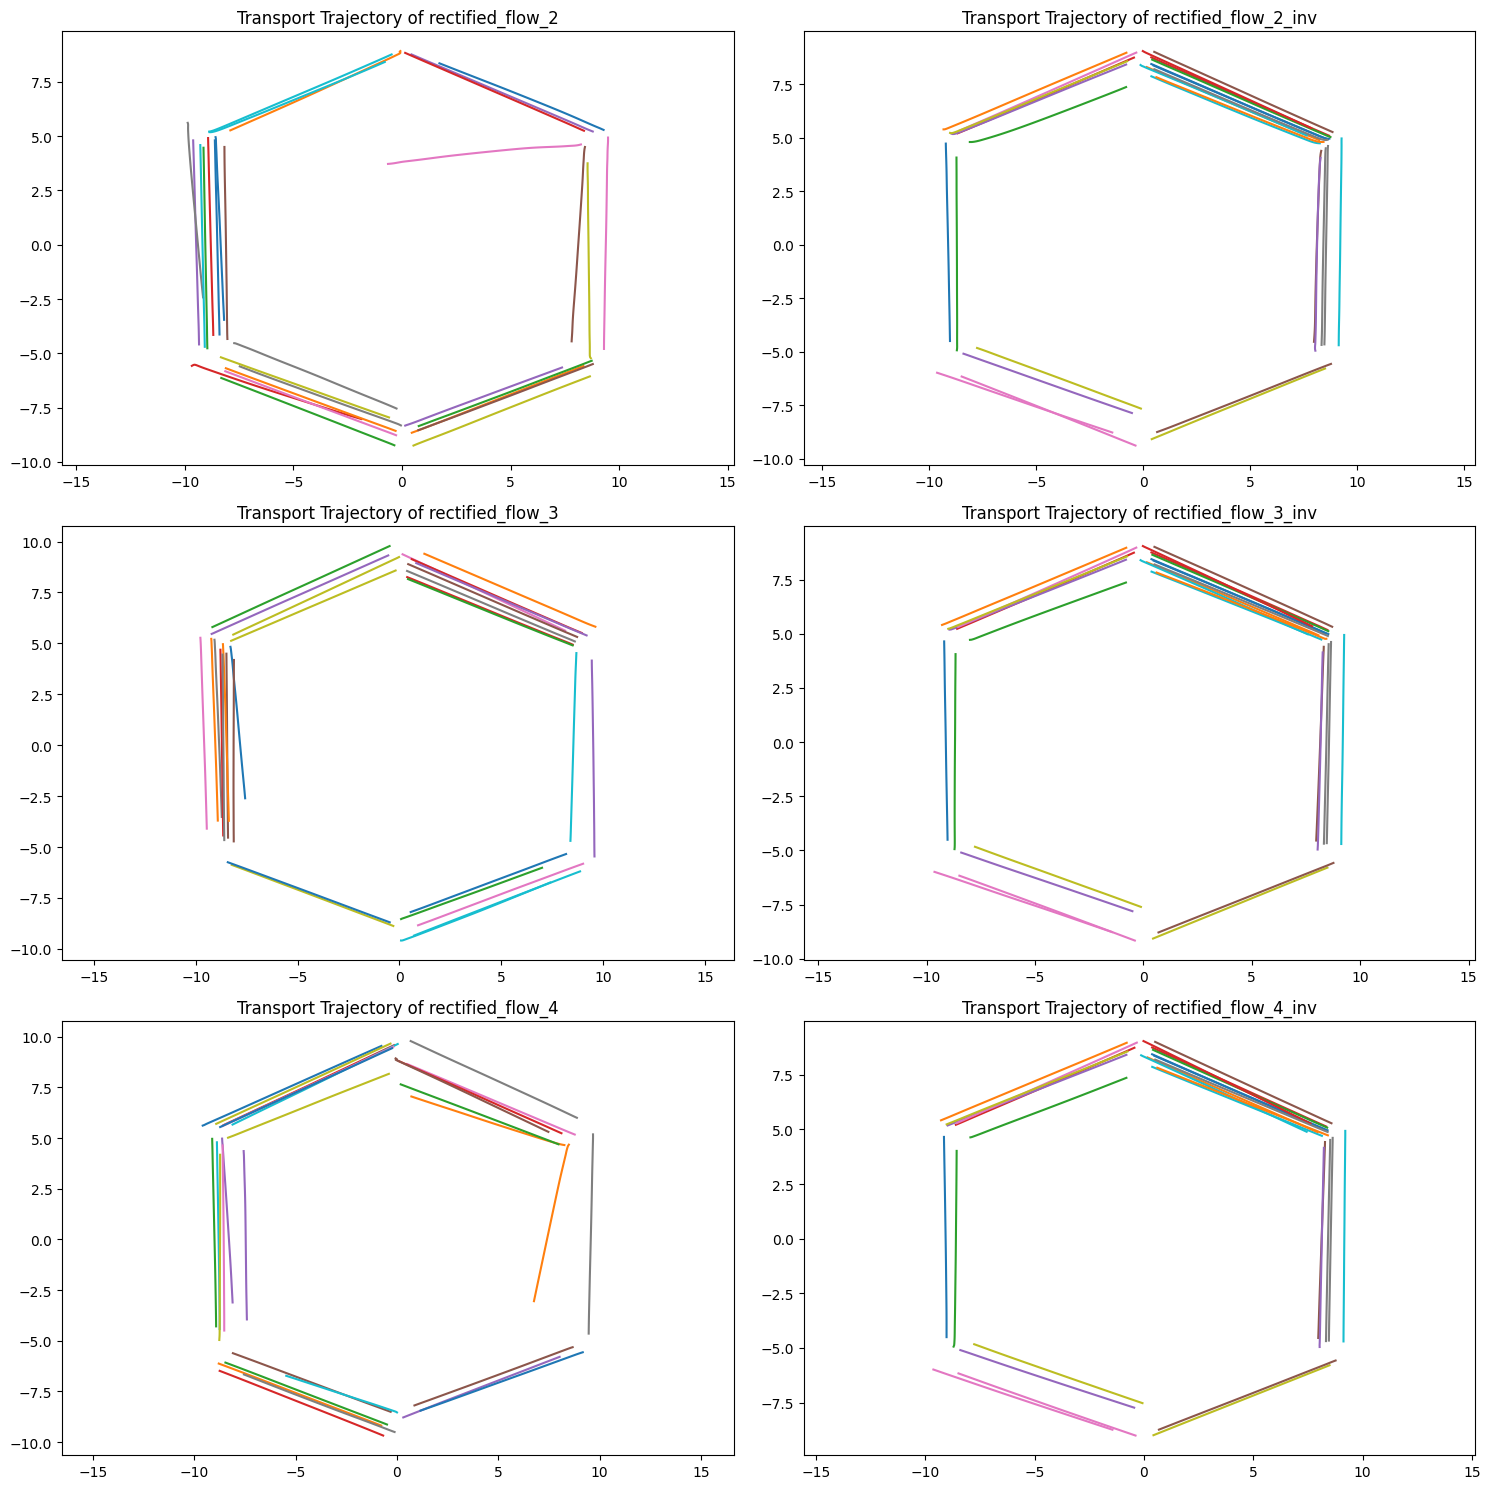

In [43]:
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
flows = [(rectified_flow_2, rectified_flow_2_inv), (rectified_flow_3, rectified_flow_3_inv), 
         (rectified_flow_4, rectified_flow_4_inv)]
names = [('rectified_flow_2', 'rectified_flow_2_inv'), ('rectified_flow_3', 'rectified_flow_3_inv'), 
         ('rectified_flow_4', 'rectified_flow_4_inv')]

for i, ax in enumerate(axes):
    z0 = initial_model.sample([1000])
    z1 = samples_1.detach().clone()

    traj = flows[i][0].sample_ode(z0=z0, N=100)
    traj_particles = torch.stack(traj)
    ax[0].set_xlim(-M,M)
    ax[0].set_ylim(-M,M)
    #v.scatter()
    ax[0].axis('equal')
    for k in range(30):
        ax[0].plot(traj_particles[:, k, 0], traj_particles[:, k, 1])
    ax[0].set_title(f'Transport Trajectory of {names[i][0]}')

    traj = flows[i][1].sample_ode(z1=z1, N=100)
    traj_particles = torch.stack(traj)
    ax[1].set_xlim(-M,M)
    ax[1].set_ylim(-M,M)
    #v.scatter()
    ax[1].axis('equal')
    for k in range(30):
        ax[1].plot(traj_particles[:, k, 0], traj_particles[:, k, 1])
    ax[1].set_title(f'Transport Trajectory of {names[i][1]}')

plt.tight_layout()

By looking at samples from original and inverse flows, we can see, that inverse approach works much better. It really moved one distribution to another without blowout.